## Inference Code for 'Neural Nano-Optics for High-quality Thin Lens Imaging'

#### This notebook can be used to produce the experimental reconstructions shown in the manuscript and in the supplemental information.

In [1]:
import tensorflow as tf
for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)


import tensorflow_addons as tfa
import numpy as np
from networks.select import select_G
from args import parse_args
import metasurface.solver as solver
import metasurface.conv as conv
import matplotlib.pyplot as plt
import sys

In [2]:
# Set up the arguments for real inference
sys.argv=['','--train_dir','.',\
             '--test_dir' ,'.',\
             '--save_dir' ,'.',\
             '--ckpt_dir' ,'experimental/ckpt/',\
             '--real_psf' ,'./experimental/data/psf/psf.npy',\
             '--psf_mode' ,'REAL_PSF',\
             '--conv_mode','REAL',\
             '--conv'     ,'full_size']
args = parse_args()

Namespace(G_beta1=0.9, G_iters=1, G_lr=0.0001, G_network='FP', Norm_loss_weight=1.0, P_loss_weight=0.0, Phase_beta1=0.9, Phase_iters=1, Phase_lr=0.005, Spatial_loss_weight=0.0, a_poisson=4e-05, alpha=270.176968209, aug_rotate=False, b_sqrt=1e-05, batch_weights=[1.0], bound_val=1000.0, ckpt_dir='experimental/ckpt/', conv='full_size', conv_mode='REAL', do_taper=True, log_freq=500, loss_mode='L1', mag=8.1, max_to_keep=2, metasurface='zeros', normalize_psf=False, num_coeffs=8, offset=True, psf_mode='REAL_PSF', real_psf='./experimental/data/psf/psf.npy', s1=0.0009, s2=0.0014, save_dir='.', save_freq=1000, snr_init=4.0, snr_opt=False, steps=1000000000, target_wavelength=5.11e-07, test_dir='.', theta_base=[0.0, 5.0, 10.0, 15.0], train_dir='.', use_general_phase=False, vgg_layers='block2_conv2,block3_conv2')


In [3]:
with tf.device('/CPU:0'):
    # Initialize and restore deconvolution method
    params = solver.initialize_params(args)
    params['conv_fn'] = conv.convolution_tf(params, args)
    params['deconv_fn'] = conv.deconvolution_tf(params, args)

    snr = tf.Variable(args.snr_init, dtype=tf.float32)
    G = select_G(params, args)
    checkpoint = tf.train.Checkpoint(G=G, snr=snr)

    status = checkpoint.restore(tf.train.latest_checkpoint(args.ckpt_dir, latest_filename=None))
    status.expect_partial()

def phase_func(x,a2,a4,a6,a8,a10,a12,a14,a16): return a2*x**2 + a4*x**4 + a6*x**6 + a8*x**8 + a10*x**10 + a12*x**12 + a14*x**14 + a16*x**16
360
Image width: 720
PSF width: 360
Load width: 1440
Network width: 1080
Out width: 720

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x000002B0036B1E88> and <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000002AFB61D1988>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x000002B0036B97C8> and <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000002AFCF524888>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x000002B0036CAE48> and <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000002AFCF548888>).

Two checkpoint references resolved to different objects (<keras.engine.sequential.Sequential object at 0x000002B009ED2CC8> and <keras.layers.core.tf_op_layer.TFOpLam

# Perform deconvolution

In [4]:
# Check that the dimensions agree with experimental captures
assert(params['image_width'] == 720)
assert(params['psf_width'] == 360)
assert(params['network_width'] == 1080)

In [5]:
# Load in experimentally measured PSFs
psf = (np.load('./experimental/data/psf/psf.npy'))
psf = tf.constant(psf)
psf = tf.image.resize_with_crop_or_pad(psf, params['psf_width'], params['psf_width'])
psf = psf / tf.reduce_sum(psf, axis=(1,2), keepdims=True)

In [46]:
def reconstruct(img_name, psf, snr, G):
    img = np.load(img_name)
    _, G_img, _ = params['deconv_fn'](img, psf, snr, G, training=False)
    G_img_ = G_img.numpy()[0,:,:,:]
    G_img_original = G_img_
    # Vignette Correct
    vig_factor = np.load('experimental/data/vignette_factor.npy')[0,:,:,:]
    G_img_ = G_img_ * vig_factor
    
    # Gain
    G_img_ = G_img_ * 1.2
    G_img_[G_img_ > 1.0] = 1.0

    # Contrast Normalization
    minval = np.percentile(G_img_, 5)
    maxval = np.percentile(G_img_, 95)
    G_img_ = np.clip(G_img_, minval, maxval)
    G_img_ = (G_img_ - minval) / (maxval - minval)
    G_img_[G_img_ > 1.0] = 1.0

    plt.figure(figsize=(6,6))
    plt.imshow(G_img_)

    return G_img_original

### Reconstruct Images

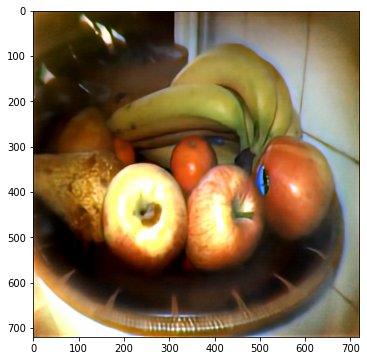

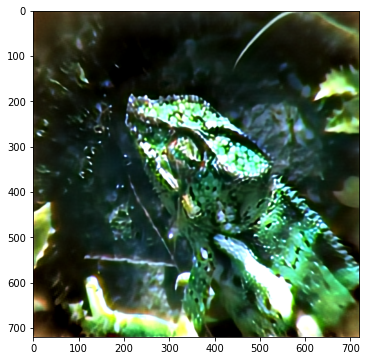

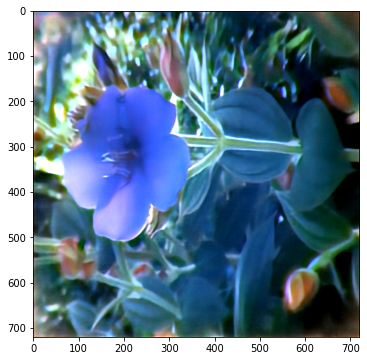

In [7]:
# Figure 3
reconstruct('./experimental/data/captures/138301.npy', psf, snr, G)
reconstruct('./experimental/data/captures/102302.npy', psf, snr, G)
reconstruct('./experimental/data/captures/110802.npy', psf, snr, G)

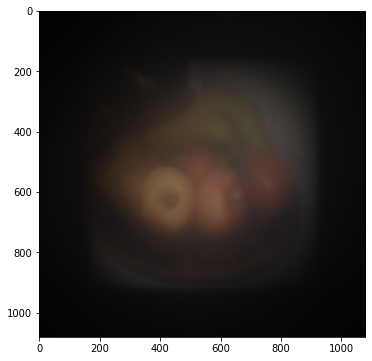

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(np.load('./experimental/data/captures/138301.npy')[0])
plt.show()

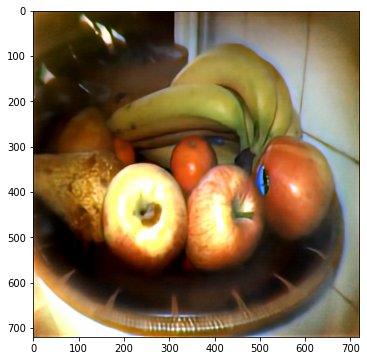

In [9]:
reconstruct('./experimental/data/captures/138301.npy', psf, snr, G)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


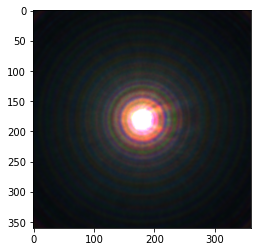

In [10]:
plt.imshow(psf[0]*20000)

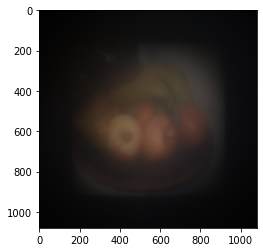

In [11]:
input_img = tf.constant(np.load('./experimental/data/captures/138301.npy'))
plt.imshow(input_img[0])

In [18]:
def padding(I, img):
    I_shape = np.array(I.shape[1:]).astype("int")
    img_shape = np.array(np.shape(img)[:-1]).astype("int")
    pad_shape = img_shape-I_shape
    middle = np.floor((I_shape+1)/2.0).astype("int")
    I_pad = tf.concat([
        I[:, middle[0]:],
        tf.zeros([3, pad_shape[0], I_shape[1]], tf.dtypes.complex64),
        I[:, :middle[0]]
    ], 1)

    I_pad = tf.concat([
        I_pad[:, :, middle[0]:],
        tf.zeros([3, img_shape[0], pad_shape[1]], tf.dtypes.complex64),
        I_pad[:, :, :middle[0]]
    ], 2)
    return I_pad

psf_pad = padding(tf.cast(tf.transpose(psf[0], [2,0,1]), tf.dtypes.complex64), input_img[0])
# plt.imshow(tf.abs(I_pad[1])**0.2)


In [34]:
H = tf.signal.fft2d(psf_pad)
Y = tf.signal.fft2d(tf.cast(tf.transpose(input_img[0], [2, 0, 1]), tf.dtypes.complex64))

360

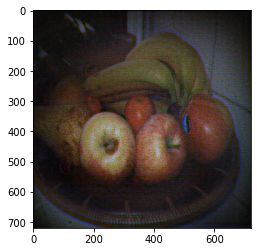

In [76]:
K=0.0001
X = Y*tf.math.conj(H)/(tf.cast(tf.abs(H)**2, tf.dtypes.complex64)+K)
wiener_result = tf.transpose(tf.abs(tf.signal.ifft2d(X)), [1, 2, 0])
mx = int(psf.shape[1]/2)
my = int(psf.shape[1]/2)
wiener_result = wiener_result[mx:-mx, my:-my]
plt.imshow(wiener_result)


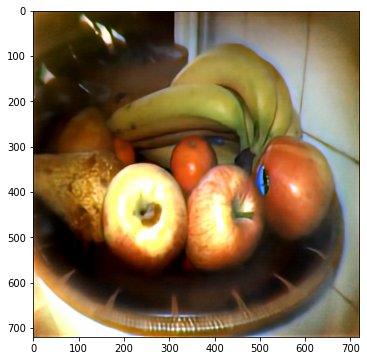

In [77]:
ml_result = reconstruct('./experimental/data/captures/138301.npy', psf, snr, G)

In [85]:
plt.figure(figsize=(6,6))
plt.subplot(1, 3, 1)
plt.title("Neural Nano Optics")
plt.imshow(ml_result)
plt.subplot(1, 3, 2)
plt.title("Wiener Filter")
plt.imshow(wiener_result)
plt.subplot(1, 3, 3)
plt.title("Difference x10")
plt.imshow(np.abs(ml_result-wiener_result)*10)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


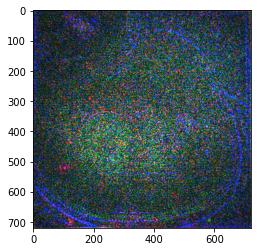